In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:75% !important; }</style>'))

In [2]:
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from PIL import Image
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from ipywidgets import Video
from sklearn.metrics import ndcg_score

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
import joblib
import sys
import os
import cv2
import torch
import glob
import imageio
import time
import imutils
import pickle
import bz2
import PIL
import io
import lzma
import psutil

import _pickle as cPickle

cv2.setNumThreads(1)

# initialize pandas apply progress bar
tqdm.pandas()

In [5]:
print(f'Python version: {sys.version}')
print(f'Torch version: {torch.__version__}')
print(f'Numpy version: {np.__version__}')

Python version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Torch version: 1.7.1
Numpy version: 1.19.2


In [6]:
# CONFIG
DEBUG = False
DEBUG_SIZE = int(1e2)
DATASET = 'ngt'
FPS = 10
FRAME_RANGE = 2
FPS_POSTFIX = f'_{FPS}fps' if FPS is not None else ''

# Key Frame Extraction
ALLOW_OF_KFE = False
ALLOW_OPEN_POSE_KFE = True
if ALLOW_OF_KFE and ALLOW_OPEN_POSE_KFE:
    raise Exception('Can\'t have both OF and OPEN_POSE KFE')

if ALLOW_OF_KFE:
    OF_KFE_POSTFIX = '_of_kfe'
elif ALLOW_OPEN_POSE_KFE:
    OF_KFE_POSTFIX = '_op_kfe'
else:
    OF_KFE_POSTFIX = ''

POSTFIX = f'{OF_KFE_POSTFIX}_fr{FRAME_RANGE}'

TARGET_IMG_SIZE = 224
N_MFF_FRAMES = 4
N_OPTICAL_FLOW_FRAMES = 3
N_FRAMES = 3 + N_OPTICAL_FLOW_FRAMES * 2
N_IMAGES = 1 + N_OPTICAL_FLOW_FRAMES * 2
N_TIME_POINTS = 1 + N_OPTICAL_FLOW_FRAMES
DATASET_POSTFIX = '_300'

DATASET_NAME = f'{DATASET}{DATASET_POSTFIX}_{N_MFF_FRAMES}-MFFs-{N_OPTICAL_FLOW_FRAMES}f1c{FPS_POSTFIX}{POSTFIX}'

if DATASET == 'jester':
    DATASET_FOLDER = 'C:/Users/markw/Downloads/20bn-jester-v1'
else:
    DATASET_FOLDER = f'C:/Users/markw/Downloads/{DATASET}{FPS_POSTFIX}'
    
# config check
print(f'DATASET: {DATASET}, FPS_POSTFIX: {FPS_POSTFIX}, DATASET_NAME: {DATASET_NAME}')

DATASET: ngt, FPS_POSTFIX: _10fps, DATASET_NAME: ngt_300_4-MFFs-3f1c_10fps_op_kfe_fr2


In [7]:
def plot_mffs(mffs):
    fig, axes = plt.subplots(N_MFF_FRAMES, N_IMAGES, figsize=(15,N_MFF_FRAMES*2))
    if type(mffs) == np.ndarray:
        for row in range(N_MFF_FRAMES):
            for col in range(N_IMAGES):
                if col == N_IMAGES - 1:
                    rgb_img = mffs[row * N_FRAMES + col:row * N_FRAMES + col + 3]
                    rgb_img = np.moveaxis(rgb_img, 0, 2).astype(np.uint8)
                    axes[row, col].imshow(rgb_img)
                else:
                    axes[row, col].imshow(mffs[row * N_FRAMES + col].astype(np.uint8))
                # Disable Axis
                axes[row, col].axis(False)
    else:
        for row, mff_options in enumerate(mffs):
            for col, img in enumerate(mff_options[0]):
                axes[row, col].imshow(img)
    plt.show()

# Image File Paths

In [8]:
# get number of frames for each video
def count_n_frames(folder_name, absolute_path=False, postfix='', debug=False):
    if absolute_path:
        return len(glob.glob(f'{folder_name}/*'))
    else:
        fp = f'{DATASET_FOLDER}{postfix}/rgb/{folder_name}/*'
        if debug:
            print(f'count_n_frames file_path: {fp}')
        return len(glob.glob(fp))

In [9]:
def countdir(folder_path):
    return len(glob.glob(f'{folder_path}/*'))

# check if Optical Frames are computed
def is_of_created(folder, n_frames):
    # get number of frames
    flow_y_frames = countdir(f'{DATASET_FOLDER}/flow/y/{folder}')
    # check if rgb frames - 1 (first frame has no previous frame) equals amount of optical flow frames
    # check if of_stats are created
    of_stats_created = os.path.exists(f'{DATASET_FOLDER}/flow/stats/{folder}.pkl')
    
    return (n_frames - 1) == flow_y_frames and of_stats_created

# Create MFFs

In [17]:
def load_image(file_path, crop_resize, width_shift=0.20, benchmark=False):
    if benchmark:
        t_start = time.time()
    
    img = imageio.imread(file_path)
    
    if benchmark:
        print(f'Reading Image Took: {((time.time() - t_start) * 1000):.2f}ms')
        t_start = time.time()
    
    if crop_resize:
        h, w = img.shape[:2]
        w_width_shift = int(h * (1 + width_shift * 2))
        scale = TARGET_IMG_SIZE / h
        # width shift range is larger than image width
        if w_width_shift > w:
            img = cv2.resize(img, (int(w * (TARGET_IMG_SIZE / h)), TARGET_IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        else:
            x_offset = (w - w_width_shift) // 2
            img = img[:, x_offset:x_offset+w_width_shift]
            img = cv2.resize(img, (int(w_width_shift * scale), TARGET_IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    
    if benchmark:
        print(f'Resizing Image Took: {((time.time() - t_start) * 1000):.2f}ms')
    
    return img

In [18]:
def get_image_cache(cache, frame_name, subset, folder, postfix, crop_resize, debug=False, benchmark=False):
    if benchmark:
        t_start = time.time()
        
    if frame_name in cache and subset in cache[frame_name]:
        if debug:
            print(f'Using cached image {subset} in frame name {frame_name} folder {folder}')
        frame = cache[frame_name][subset]
    else:
        frame = load_image(f'{DATASET_FOLDER}{postfix}/{subset}/{folder}/{frame_name}.jpg', crop_resize)
        if frame_name in cache:
            cache[frame_name][subset] = frame
        else:
            cache[frame_name] = { subset: frame }
            
    if benchmark:
        print(f'Loading Image {subset} Took: {((time.time() - t_start) * 1000):.2f}ms')
        
    return frame

In [19]:
def create_images(row, postfix='', crop_resize=False, frame_range=0, debug=False, benchmark=False):
    folder = row['folder']
    res = []
    if 'keyframe_idxs' not in row:
        keyframe_idxs = get_keyframe_idxs(row['folder'], row['frame_count'], debug=debug)
    else:
        keyframe_idxs = row['keyframe_idxs']
    if debug:
        print(f'keyframe_idxs: {keyframe_idxs}')
    
    # For each keyframe idx
    cache = dict()
    for row_idx, keyframe_idx in enumerate(keyframe_idxs):
        if benchmark:
            t_start = time.time()
        
        min_frame_idx = max(N_OPTICAL_FLOW_FRAMES + 1, keyframe_idx - frame_range)
        min_frame_idx = max(min_frame_idx, min(keyframe_idxs))
        
        max_frame_idx = min(row['frame_count'], keyframe_idx + frame_range)
        max_frame_idx = min(max_frame_idx, max(keyframe_idxs))
        
        if debug:
            print(f'min_frame_idx: {min_frame_idx}, max_frame_idx: {max_frame_idx}')
        
        frame_options = []
        for frame_idx in range(min_frame_idx, max_frame_idx + 1):
            mff = []
            
            # OPTICAL FLOW
            of_frame_idx = 1
            ofs_created = 0
            while ofs_created < N_OPTICAL_FLOW_FRAMES:
                # read optical flow frames
                frame_name = str(frame_idx - of_frame_idx).rjust(5, '0')
                frame_ofx = get_image_cache(cache, frame_name, 'flow/x', folder, postfix, crop_resize, debug=debug, benchmark=benchmark)
                # Check Null Optical Flow Frame  or (frame_idx - of_frame_idx) - (N_OPTICAL_FLOW_FRAMES - ofs_created) < 1
                if frame_ofx.std() > 0 or (frame_idx - of_frame_idx) - (N_OPTICAL_FLOW_FRAMES - ofs_created) < 1:
                    # Only read y frame is x is not none
                    frame_ofy = get_image_cache(cache, frame_name, 'flow/y', folder, postfix, crop_resize, debug=debug, benchmark=benchmark)
                    # assign optical flow frames to result
                    mff = [frame_ofx, frame_ofy] + mff
                    ofs_created += 1
                    
                of_frame_idx += 1
            
            # RGB frame
            frame_name = str(frame_idx).rjust(5, '0')
            frame_rgb = get_image_cache(cache, frame_name, 'rgb', folder, postfix, crop_resize, debug=debug, benchmark=benchmark)
            
            mff += [frame_rgb]
            
            # add mff to frame options
            frame_options.append(mff)
            
        res.append(frame_options)
        
        if benchmark:
            print(f'MFF took: {((time.time() - t_start) * 1000):.2f}ms')
            
    return res

# row = jester_df.loc[jester_df['label'] == 'Swiping Left'].iloc[100]
# row = jester_df.sample(1).squeeze()
# row = train.sample(1).squeeze()
# display(row)
# res = create_images(row, crop_resize=True, frame_range=3, debug=False)
# plot_mffs(res)

# Optical Flow Key Frame Extraction

In [20]:
def load_of_stats(folder, postfix='', debug=False):
    fp = f'{DATASET_FOLDER}{postfix}/flow/stats/{folder}.pkl'
    try:
        with bz2.BZ2File(fp, 'rb') as f:
            return pickle.load(f)
    except:
        if debug:
            print(f'Could not load of stats with file path: {fp}')

In [21]:
def get_min_start_idx(of_stats, debug=False):
    min_start_idx = 1
    count = 0
    for of_x_std, of_y_std in zip(of_stats['x'][f'stds'], of_stats['y'][f'stds']):
        min_start_idx += 1
        if of_x_std != 0 and of_y_std != 0:
            count += 1
        
        if count == N_OPTICAL_FLOW_FRAMES:
            break
            
    return min_start_idx

In [22]:
# get start and end frame optical flow based
def get_start_end_frame_idx(of_stats, n_frames, threshold=0.10, debug=False):
    of_std_max = max(of_stats['x'][f'stds'] + of_stats['y'][f'stds'])
    # Start Frame Index
    start_idx = 1
    for of_x_std, of_y_std in zip(of_stats['x'][f'stds'], of_stats['y'][f'stds']):
        if max(of_x_std, of_y_std) < of_std_max * threshold:
            start_idx += 1
        else:
            break
          
    # End Frame Index
    end_idx = n_frames - 2 # zero index minus last frame
    for of_x_std, of_y_std in zip(reversed(of_stats['x'][f'stds']), reversed(of_stats['y'][f'stds'])):
        if max(of_x_std, of_y_std) < of_std_max * threshold:
            end_idx -= 1
        else:
            break
            
    # get min start idx to filter out identical frames
    min_start_idx = get_min_start_idx(of_stats, debug=debug)
    start_idx_guarded = max(start_idx, min_start_idx)
    if debug:
        print(f'Start idx guard changed start_idx from {start_idx} to {start_idx_guarded}')
            
    # start idx of first OF above threshold
    # end idx + 1, RGB frame with OF frame above threshold
    return start_idx_guarded, end_idx + 1

In [23]:
# get keyframes, optical flow based
def get_keyframe_idxs_of_kfe(folder, n_frames, postfix='', debug=False):
    of_stats = load_of_stats(folder, postfix=postfix, debug=debug)
    
    if debug:
        print('Optical Flow Stats loaded successfully')
    
    start_idx, end_idx = get_start_end_frame_idx(of_stats, n_frames, debug=debug)
    # Make sure start_idx is smaller or equal to end_idx
    end_idx = max(start_idx, end_idx)
    if debug:
        print(f'start_idx: {start_idx}, end_idx: {end_idx}, n_frames: {n_frames}')
        
    offset = max(N_OPTICAL_FLOW_FRAMES + 1, start_idx)
    n_usable_frames = max(0, end_idx - offset)
    segment_size = n_usable_frames / (N_MFF_FRAMES - 1)
    
    if debug:
        print(f'offset: {offset}, n_usable_frames: {n_usable_frames}, segment_size: {segment_size}')
    
    frame_idxs = [offset + int(i * segment_size) for i in range(N_MFF_FRAMES)]
    
    return tuple(frame_idxs)

In [24]:
# get keyframes, linear based
def get_keyframe_idxs_linear(n_frames, debug=False):
    offset = N_OPTICAL_FLOW_FRAMES + 1
    n_usable_frames = n_frames - N_OPTICAL_FLOW_FRAMES - 1
    segment_size = n_usable_frames / N_MFF_FRAMES
    frame_idxs = [offset + int((i + 0.50) * segment_size) for i in range(N_MFF_FRAMES)]
    
    return tuple(frame_idxs)

get_keyframe_idxs_linear(33)

(7, 14, 22, 29)

In [25]:
def get_keyframe_idxs(folder, n_frames=None, postfix='', debug=False):
    if n_frames is None:
        fp = f'{DATASET_FOLDER}{postfix}/rgb/{folder}'
        n_frames = count_n_frames(fp, absolute_path=True)
        if debug:
            print(f'frame count determined: {n_frames}, fp: {fp}')

    try:
        if ALLOW_OF_KFE:
            res = get_keyframe_idxs_of_kfe(folder, n_frames, postfix=postfix, debug=debug)
            if debug:
                print('Succesfully using Optical Flow Key Frame Extraction')
        else:
            if debug:
                print('Optical Flow KFE Not Allowed, Using Linear KFE')
            return get_keyframe_idxs_linear(n_frames, debug=debug)
        return res
    except:
        if debug:
            print('Falling back to linear key frame extraction')
        return get_keyframe_idxs_linear(n_frames, debug=debug)
    
get_keyframe_idxs(1, debug=True)

frame count determined: 31, fp: C:/Users/markw/Downloads/ngt_10fps/rgb/1
Optical Flow KFE Not Allowed, Using Linear KFE


(7, 14, 20, 27)

# NGT Pickle Generation

In [13]:
if DATASET == 'ngt':
    SIGNBANK2FOLDER_DICT = pd.read_pickle(f'train_ngt_dxy{FPS_POSTFIX}.pkl').set_index('Signbank ID')['folder_index'].to_dict()

In [14]:
N = 300

if N is not None:
    ### TRAIN ###
    if DATASET == 'ngt':
        if ALLOW_OPEN_POSE_KFE:
            train = pd.read_pickle(f'ngt_signbank_validation_filtered_{N}_cats_dxy_10fps.pkl.xz_open_pose_kfe.pkl.xz')
        else:
            train = pd.read_pickle(f'ngt_signbank_validation_filtered_{N}_cats.pkl.xz')
        # get label
        train['label'] = train.index
        # add folder column
        train['folder'] = train['folder_index']
        # get key frame indices
        train['frame_count'] = train['folder'].apply(count_n_frames)
        if ALLOW_OPEN_POSE_KFE:
            train['keyframe_idxs'] = train['open_pose_key_frames']
        else:
            train['keyframe_idxs'] = train['folder'].progress_apply(get_keyframe_idxs)
        # diplay DF used
        display(train.sample(10))

    ### VALIDATIOn ###
    if DATASET == 'ngt':
        if ALLOW_OPEN_POSE_KFE:
            val = pd.read_pickle(f'ngt_signbank_validation_filtered_{N}_cats_dxy_10fps.pkl.xz_open_pose_kfe_val.pkl.xz')
        else:
            val = pd.read_pickle(f'ngt_signbank_validation_filtered_{N}_cats.pkl.xz')
        # get label
        val['label'] = val.index
        val = val.loc[val['is_val'] == 'X']
        # add folder column
        val['folder'] = val['folder_index']
        # get key frame indices
        val['frame_count'] = val['folder'].apply(count_n_frames, postfix='_val')
        if ALLOW_OPEN_POSE_KFE:
            val['keyframe_idxs'] = val['open_pose_key_frames_val']
        else:
            val['keyframe_idxs'] = val['folder'].progress_apply(get_keyframe_idxs, postfix='_val')
        # diplay DF used
        display(val.sample(10))
else:
    if ALLOW_OPEN_POSE_KFE:
        train = pd.read_pickle('train_ngt_dxy_10fps.pkl_open_pose_kfe.pkl.xz')
    else:
        train = pd.read_pickle('train_ngt_dxy_10fps.pkl')
    
    train['folder'] = train['folder_index']
    
    if ALLOW_OPEN_POSE_KFE:
        train['keyframe_idxs'] = train['open_pose_key_frames']
    else:
        train['keyframe_idxs'] = train['folder'].progress_apply(get_keyframe_idxs)
    
    display(train.head(25))

,Unnamed: 0,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),folder_index,Annotation ID Gloss (Dutch),...,right_dy_rolling4_10fps_val,left_dx_rolling5_10fps_val,left_dy_rolling5_10fps_val,right_dx_rolling5_10fps_val,right_dy_rolling5_10fps_val,open_pose_key_frames,label,folder,frame_count,keyframe_idxs
123,123,123,X,Pasco,799,NGT,NETJES-B,NaN,2196,NETJES-B,...,"(0.0, 0, -0.3475443522135417, -5.5051193237304...","(0.0, 0, 5.660725911458333, 9.254840850830078,...","(0.0, 0, -3.9972737630208335, -7.2448272705078...","(0.0, 0, -5.672627766927083, -9.25151634216308...","(0.0, 0, -0.3475443522135417, -5.5051193237304...","(4, 10, 14, 20)",123,2196,32,"(4, 10, 14, 20)"
217,217,217,X,Onno,658,NGT,PERSOON-A.PL,NaN,2542,PERSOON-A.PL,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5, 11, 16, 24)",217,2542,34,"(5, 11, 16, 24)"
134,134,134,X,Stijn,1586,NGT,MELK,NaN,2056,MELK,...,"(0.0, 0, 0.3341064453125, -0.00390625, 0.00383...","(0.0, 0, 0.32403564453125, 0.00066375732421875...","(0.0, 0, -0.336181640625, -0.2464752197265625,...","(0.0, 0, 0.6617177327473959, -0.25038909912109...","(0.0, 0, 0.3341064453125, -0.00390625, 0.00307...","(4, 11, 16, 23)",134,2056,30,"(4, 11, 16, 23)"
294,294,294,NaN,NaN,1488,NGT,SIMPEL,NaN,2932,SIMPEL,...,(),(),(),(),(),"(4, 12, 18, 21)",294,2932,32,"(4, 12, 18, 21)"
148,148,148,X,Stijn,1986,NGT,BLIJ-B,NaN,551,BLIJ-B,...,"(0.0, 0, 0.0019734700520833335, -0.00117492675...","(0.0, 0, 0.33734130859375, 0.2534637451171875,...","(0.0, 0, -0.6659037272135416, 0.00197601318359...","(0.0, 0, 0.3175913492838542, -0.00240707397460...","(0.0, 0, 0.0019734700520833335, -0.00117492675...","(6, 12, 19, 28)",148,551,43,"(6, 12, 19, 28)"
66,66,66,X,Mark-Bank,563,NGT,LIJKEN-OP,NaN,1915,LIJKEN-OP,...,"(0.0, 0, -0.00152587890625, 0.2462158203125, 0...","(0.0, 0, -0.3186289469401042, -0.2434043884277...","(0.0, 0, -0.3339742024739583, 0.50407409667968...","(0.0, 0, -0.33917236328125, -0.504013061523437...","(0.0, 0, -0.00152587890625, 0.2462158203125, 0...","(5, 10, 20, 23)",66,1915,32,"(5, 10, 20, 23)"
211,211,211,X,Jelle,2778,NGT,MOGEN-B,NaN,2117,MOGEN-B,...,"(0.0, 0, 0.650421142578125, 0.247833251953125,...","(0.0, 0, -0.659820556640625, -0.25269317626953...","(0.0, 0, 0.998016357421875, 0.7459564208984375...","(0.0, 0, 0.0035552978515625, -0.24291229248046...","(0.0, 0, 0.650421142578125, 0.247833251953125,...","(5, 8, 11, 15)",211,2117,22,"(5, 8, 11, 15)"
263,263,263,NaN,NaN,2340,NGT,NIKS-B,NaN,2218,NIKS-B,...,(),(),(),(),(),"(4, 7, 16, 26)",263,2218,38,"(4, 7, 16, 26)"
109,109,109,X,Pasco,4610,NGT,CYPRUS-B,NaN,745,CYPRUS-B,...,"(0.0, 0, -8.335347493489584, -13.006103515625,...","(0.0, 0, -3.670588175455729, -8.00341033935546...","(0.0, 0, -9.667734781901041, -13.7569961547851...","(0.0, 0, -3.3480606079101562, -1.0105609893798...","(0.0, 0, -8.335347493489584, -13.006103515625,...","(5, 8, 16, 31)",109,745,42,"(5, 8, 16, 31)"
107,107,107,X,Mark-Bank,735,NGT,VERHUIZEN-C,NaN,3444,VERHUIZEN-C,...,"(0.0, 0, -0.0010274251302083333, -0.0009307861...","(0.0, 0, -1.4991200764973958, -2.5618324279785...","(0.0, 0, -0.000640869140625, -0.00052642822265...","(0.0, 0, -1.6644821166992188, -1.7440338134765...","(0.0, 0, -0.0010274251302083333, -0.0009307861...","(4, 8, 15, 22)",107,3444,32,"(4, 8, 15, 22)"


,Unnamed: 0,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),folder_index,Annotation ID Gloss (Dutch),...,left_dx_rolling5_10fps_val,left_dy_rolling5_10fps_val,right_dx_rolling5_10fps_val,right_dy_rolling5_10fps_val,missing_coords_p,open_pose_key_frames_val,label,folder,frame_count,keyframe_idxs
218,218,218,X,Onno,1632,NGT,ZEBRAPAD,NaN,3805,ZEBRAPAD,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.166667,"(25, 32, 36, 40)",218,3805,60,"(25, 32, 36, 40)"
99,99,99,X,Pasco,3441,NGT,KERMIS-C,NaN,1675,KERMIS-C,...,"(0.0, 0, -8.651911417643229, 0.265857696533203...","(0.0, 0, -17.331095377604168, -35.745330810546...","(0.0, 0, 2.3416875203450522, -0.49673080444335...","(0.0, 0, -17.995005289713543, -28.995491027832...",0.000000,"(7, 12, 17, 22)",99,1675,28,"(7, 12, 17, 22)"
161,161,161,X,Steven,856,NGT,EERLIJK-C,NaN,938,EERLIJK-C,...,"(0.0, 0, 1.3347625732421875, 1.744571685791015...","(0.0, 0, 0.011118570963541666, -0.238243103027...","(0.0, 0, 1.6536153157552083, 1.500423431396484...","(0.0, 0, -1.672760009765625, -0.50894165039062...",0.000000,"(7, 11, 16, 27)",161,938,43,"(7, 11, 16, 27)"
166,166,166,X,Steven,4613,NGT,KENNEN-NIET,NaN,1668,KENNEN-NIET,...,"(0.0, 0, 0.3388163248697917, 0.253292083740234...","(0.0, 0, 0.3161824544270833, 0.740509033203125...","(0.0, 0, 0.9951833089192709, 1.003406524658203...","(0.0, 0, 0.005045572916666667, 0.5000457763671...",0.011905,"(13, 18, 32, 39)",166,1668,42,"(13, 18, 32, 39)"
226,226,226,X,Onno,897,NGT,REIZEN-A,NaN,2745,REIZEN-A,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.589474,"(19, 26, 30, 34)",226,2745,55,"(19, 26, 30, 34)"
8,8,8,X,Mark,1265,NGT,REGERING-A,NaN,2736,REGERING-A,...,"(0.0, 0, -0.010401407877604166, 0.246368408203...","(0.0, 0, 0.0027262369791666665, -0.00563049316...","(0.0, 0, -0.6511815388997396, -0.2491111755371...","(0.0, 0, 0.0047607421875, 0.00112152099609375,...",0.000000,"(8, 12, 23, 31)",8,2736,42,"(8, 12, 23, 31)"
27,27,27,X,Mark,1472,NGT,BEMOEIEN-B,NaN,469,BEMOEIEN-B,...,"(0.0, 0, 0.992218017578125, 0.75146484375, 0.5...","(0.0, 0, 0.00023396809895833334, -0.0005035400...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 28.0973...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 61.5034...",0.114802,"(9, 18, 27, 30)",27,469,41,"(9, 18, 27, 30)"
196,196,196,X,Jelle,4617,NGT,HEILIGE-GEEST,NaN,1391,HEILIGE-GEEST,...,"(0.0, 0, 0.0017242431640625, 0.511966705322265...","(0.0, 0, -0.3399251302083333, -0.5137329101562...","(0.0, 0, -0.0014292399088541667, -0.2432289123...","(0.0, 0, -1.0003662109375, -0.9997100830078125...",0.000000,"(6, 21, 27, 30)",196,1391,38,"(6, 21, 27, 30)"
245,245,245,X,Onno,1288,NGT,BIJEENKOMEN,NaN,529,BIJEENKOMEN,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.176190,"(16, 19, 24, 28)",245,529,44,"(16, 19, 24, 28)"
15,15,15,X,Mark,2183,NGT,ZALF,NaN,3801,ZALF,...,"(0.0, 0, -0.0036824544270833335, -0.2465057373...","(0.0, 0, 0.011332194010416666, 0.0096817016601...","(0.0, 0, 0.6638946533203125, 0.001945495605468...","(0.0, 0, 0.0009053548177083334, 0.000244140625...",0.000000,"(9, 13, 24, 35)",15,3801,49,"(9, 13, 24, 35)"


In [15]:
# Compute Test Size with 100 Validation Samples
N_TEST_SAMPLES = len(val) - 100
TEST_SIZE = N_TEST_SAMPLES / len(val)
print(f'TEST_SIZE: {TEST_SIZE}')

TEST_SIZE: 0.6062992125984252


In [16]:
# Split into Validation and Test, stratify on person recorded
VAL, TEST = train_test_split(val, test_size=TEST_SIZE, random_state=42, shuffle=True, stratify=val['Person'])

In [17]:
# Show VAL and TEST size
display(VAL.info(max_cols=0))
display(TEST.info(max_cols=0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 98 to 33
Columns: 125 entries, Unnamed: 0 to keyframe_idxs
dtypes: bool(8), float64(5), int64(22), object(90)
memory usage: 93.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 182 to 246
Columns: 125 entries, Unnamed: 0 to keyframe_idxs
dtypes: bool(8), float64(5), int64(22), object(90)
memory usage: 143.2+ KB


None

In [18]:
# Check whether person tratify was succesful
print('Validation')
display(VAL['Person'].value_counts(normalize=False))
print('Test')
display(TEST['Person'].value_counts(normalize=False))

Validation


Mark-Bank    21
Mark         20
Onno         15
Steven       12
Jelle        11
Stijn        11
Pasco        10
Name: Person, dtype: int64

Test


Mark-Bank    33
Mark         30
Onno         23
Stijn        18
Steven       18
Jelle        16
Pasco        16
Name: Person, dtype: int64

In [32]:
# Check whether person tratify was succesful
print('Validation')
display(VAL['Person'].value_counts(normalize=False))
print('Test')
display(TEST['Person'].value_counts(normalize=False))

Validation


Mark-Bank    21
Mark         20
Onno         15
Steven       12
Jelle        11
Stijn        11
Pasco        10
Name: Person, dtype: int64

Test


Mark-Bank    33
Mark         30
Onno         23
Stijn        18
Steven       18
Jelle        16
Pasco        16
Name: Person, dtype: int64

# Similarity Matrices

In [24]:
train_distance_matrix = np.load(f'train_distance_matrix_{N}.npy')
print(f'train_distance_matrix shape: {train_distance_matrix.shape} train_distance_matrix dtype: {train_distance_matrix.dtype}')

train_distance_matrix shape: (300, 300) train_distance_matrix dtype: float32


In [27]:
train_distance_matrix_inversed = 1 - train_distance_matrix

In [62]:
scores = {
    1: [], 5: [], 10: [], 20: [],
}
for i in tqdm(np.random.randint(0, N, size=int(1e3))):
    y_score = np.random.rand(*train_distance_matrix_inversed.shape)
    y_true = train_distance_matrix_inversed
    for k in [1, 5, 10, 20]:
        scores[k].append(ndcg_score(y_true, y_score, k=k))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
for k in [1, 5, 10, 20]:
    print(f'MEAN NDCG@{k}: {np.mean(scores[k]):.3f}')

MEAN NDCG@1: 0.403
MEAN NDCG@5: 0.438
MEAN NDCG@10: 0.456
MEAN NDCG@20: 0.480


In [25]:
display(pd.Series(train_distance_matrix.flatten()).describe())

count    90000.000000
mean         0.596872
std          0.219326
min          0.000000
25%          0.433333
50%          0.611111
75%          0.765873
max          1.000000
dtype: float64

# Similarity Matrices Detailed

In [67]:
with lzma.LZMAFile('train_distance_matrix_detailed_300_dict.xr', 'rb') as f:
    train_distance_matrix_detailed_300_dict = pickle.load(f)
    
print(f'Keys: {list(train_distance_matrix_detailed_300_dict.keys())}')

Keys: ['handedness_distance', 'location_distance', 'movement_distance', 'strong_hand_distance', 'weak_hand_distance']


In [79]:
for key in train_distance_matrix_detailed_300_dict.keys():
    sims = 1 - train_distance_matrix_detailed_300_dict[key]
    scores = {
        1: [], 5: [], 10: [], 20: [],
    }
    for i in tqdm(np.random.randint(0, N, size=int(1e3))):
        y_score = np.random.rand(*sims.shape)
        y_true = sims
        for k in [1, 5, 10, 20]:
            scores[k].append(ndcg_score(y_true, y_score, k=k))
            
    for k in [1, 5, 10, 20]:
        print(f'MEAN {"_".join(key.split("_")[:-1]).upper()}_NDCG@{k}: {np.mean(scores[k]):.3f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

MEAN HANDEDNESS_NDCG@1: 0.453
MEAN HANDEDNESS_NDCG@5: 0.453
MEAN HANDEDNESS_NDCG@10: 0.453
MEAN HANDEDNESS_NDCG@20: 0.453


  0%|          | 0/1000 [00:00<?, ?it/s]

MEAN LOCATION_NDCG@1: 0.557
MEAN LOCATION_NDCG@5: 0.566
MEAN LOCATION_NDCG@10: 0.574
MEAN LOCATION_NDCG@20: 0.585


  0%|          | 0/1000 [00:00<?, ?it/s]

MEAN MOVEMENT_NDCG@1: 0.336
MEAN MOVEMENT_NDCG@5: 0.339
MEAN MOVEMENT_NDCG@10: 0.343
MEAN MOVEMENT_NDCG@20: 0.354


  0%|          | 0/1000 [00:00<?, ?it/s]

MEAN STRONG_HAND_NDCG@1: 0.212
MEAN STRONG_HAND_NDCG@5: 0.214
MEAN STRONG_HAND_NDCG@10: 0.218
MEAN STRONG_HAND_NDCG@20: 0.227


  0%|          | 0/1000 [00:00<?, ?it/s]

MEAN WEAK_HAND_NDCG@1: 0.234
MEAN WEAK_HAND_NDCG@5: 0.235
MEAN WEAK_HAND_NDCG@10: 0.237
MEAN WEAK_HAND_NDCG@20: 0.241


# NGT Pickle Generation

,0
Unnamed: 0,0
ID,0
is_val,X
Person,Mark
Signbank ID,1239
...,...
open_pose_key_frames,"(5, 10, 15, 20)"
label,0
folder,2457
frame_count,34


keyframe_idxs: (5, 10, 15, 20)
min_frame_idx: 5, max_frame_idx: 8
Using cached image flow/x in frame name 00004 folder 2457
Using cached image flow/y in frame name 00004 folder 2457
Using cached image flow/x in frame name 00003 folder 2457
Using cached image flow/y in frame name 00003 folder 2457
Using cached image flow/x in frame name 00005 folder 2457
Using cached image flow/y in frame name 00005 folder 2457
Using cached image flow/x in frame name 00004 folder 2457
Using cached image flow/y in frame name 00004 folder 2457
Using cached image flow/x in frame name 00006 folder 2457
Using cached image flow/y in frame name 00006 folder 2457
Using cached image flow/x in frame name 00005 folder 2457
Using cached image flow/y in frame name 00005 folder 2457
min_frame_idx: 7, max_frame_idx: 13
Using cached image flow/x in frame name 00006 folder 2457
Using cached image flow/y in frame name 00006 folder 2457
Using cached image flow/x in frame name 00005 folder 2457
Using cached image flow/y in

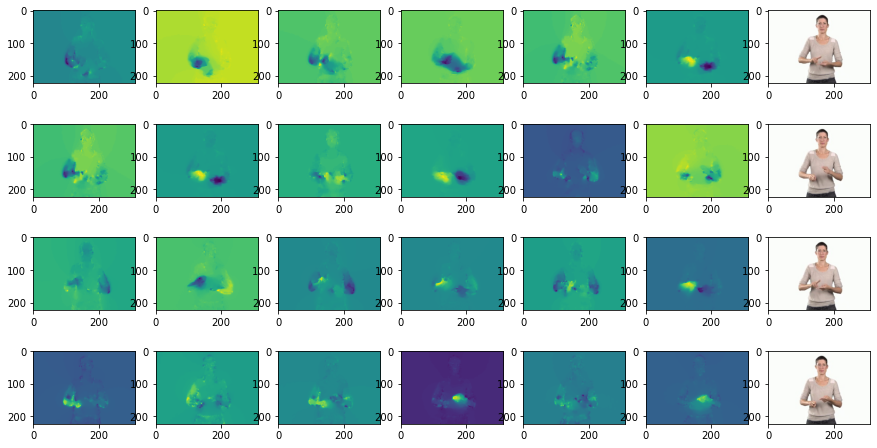

---- train ----- FR=3


  0%|          | 0/300 [00:00<?, ?it/s]

---- val ----- FR=0


  0%|          | 0/100 [00:00<?, ?it/s]

---- test ----- FR=0


  0%|          | 0/154 [00:00<?, ?it/s]

In [216]:
def process_ngt_row(row, subset, postfix, frame_range, simple_attributes):   
    mffs = create_images(row, postfix=postfix, crop_resize=True, frame_range=frame_range)
    mff = []
    frame_idx = 0
    # convert frames to PIL Images
    for mff_options in mffs:
        frame_options = []
        for frame_option in mff_options:
            frame_option_jpg = []
            for frame in frame_option:
                # save as highly compressed PNG
                frame_jpeg_bytes = io.BytesIO()
                Image.fromarray(frame).save(frame_jpeg_bytes, format='JPEG', quality=100)
                frame_option_jpg.append(frame_jpeg_bytes.getvalue())
                
            # append JPEG encoded frame options to frame options
            frame_options.append(frame_option_jpg)
        # append frame options to mff
        mff.append(frame_options)
        
    # Pad location categorie to length 2
    if not simple_attributes:
        lc = row['location cat']
        lcc = row['location cat count']
        if len(lc) == 1:
            lc = tuple([*lc, '-'])
            lcc = tuple([*lcc, 0])
     
    my_filters = [{ 'id': lzma.FILTER_LZMA2, 'preset': 1 }]
    with lzma.open(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{subset}/{row["folder"]}.xr', 'wb', filters=my_filters) as f:
        if simple_attributes:
            attributes = dict({ 'label': row['label'] })
        else:
            attributes = dict({
                'label': row['label'],
                'person': row['Person'],
                # Convert distance to similarity for correct p@k metrics
                'similarity': 1 - train_distance_matrix[row['label']],
                # Detailed Similarity
                'handedness_similarity': 1 - train_distance_matrix_detailed_300_dict['handedness_distance'][row['label']],
                'location_similarity': 1 - train_distance_matrix_detailed_300_dict['location_distance'][row['label']],
                'movement_similarity': 1 - train_distance_matrix_detailed_300_dict['movement_distance'][row['label']],
                'strong_hand_similarity': 1 - train_distance_matrix_detailed_300_dict['strong_hand_distance'][row['label']],
                'weak_hand_similarity': 1 - train_distance_matrix_detailed_300_dict['weak_hand_distance'][row['label']],
                # Location and Movement Categories
                'location cat 1': lc[0],
                'location cat count 1': lcc[0],
                'location cat 2': lc[1],
                'location cat count 2': lcc[1],
                'movement cat': row['movement cat'][0],
                'movement cat count': row['movement cat count'][0],
            })
        record = tuple([mff, attributes])
        pickle.dump(record, f)
    
def create_pickle_ngt(df, subset, postfix='', frame_range=0, simple_attributes=True):
    print(f'---- {subset} ----- FR={frame_range}')
    # Try to make output folder
    try:
        os.makedirs(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{subset}')
    except:
        pass
    
    for row_idx, row in tqdm(df.iterrows(), total=len(df)):
        process_ngt_row(row, subset, postfix, frame_range, simple_attributes=simple_attributes)
    

if DATASET == 'ngt':
    # example MFF
    row = train.iloc[0]
    display(pd.DataFrame(row))
    res = create_images(row, crop_resize=True, debug=True, frame_range=FRAME_RANGE)
    plot_mffs(res)
    # create pickles
    create_pickle_ngt(train, 'train', frame_range=FRAME_RANGE, simple_attributes=False)
    create_pickle_ngt(VAL, 'val', postfix='_val', frame_range=0, simple_attributes=False)
    create_pickle_ngt(TEST, 'test', postfix='_val', frame_range=0, simple_attributes=False)

# Jester Pickle Generation

In [11]:
if DATASET == 'jester':
    jester_df = pd.read_pickle(F'MFF-pytorch/datasets/jester-v1/jester_df.pkl')
    
    # VALIDATION SET ONLY
    if False:
        jester_df = jester_df.loc[jester_df['subset'] == 'val']
    
    # add frame count
    jester_df['frame_count'] = jester_df['n_frames']    
    # diplay DF used
    display(jester_df.sample(10))

,folder,label,subset,label_int,n_frames,frame_count
72884,135439,No gesture,train,25,37,37
103352,77202,Zooming In With Full Hand,train,16,32,32
17639,77641,Pulling Two Fingers In,train,11,38,38
54904,26531,Doing other things,train,26,37,37
44449,9813,Zooming In With Two Fingers,train,18,36,36
119108,74738,Sliding Two Fingers Left,train,6,37,37
15346,93999,Pulling Two Fingers In,train,11,37,37
6013,68376,Sliding Two Fingers Right,train,7,36,36
53488,143905,Doing other things,train,26,31,31
107617,134994,Rolling Hand Backward,train,13,29,29


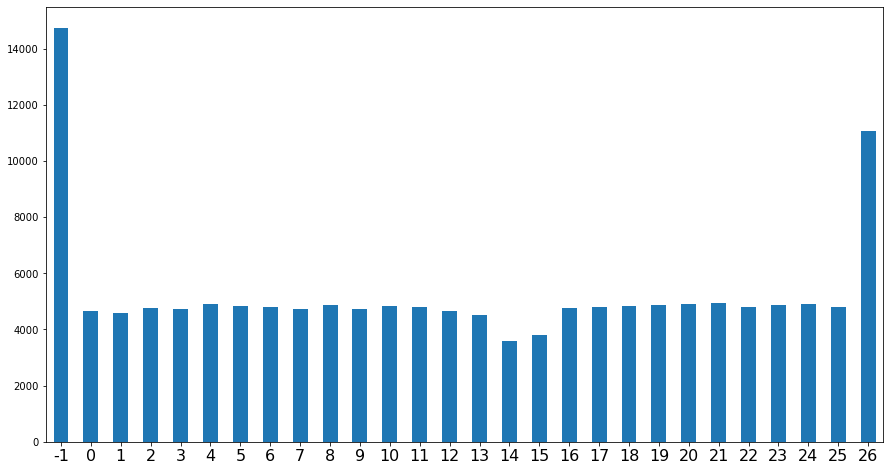

In [12]:
# show train label frequency
plt.figure(figsize=(15,8))
jester_df['label_int'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0, size=16)
plt.show()

In [33]:
# Compression benchmark 100 files
# bz2    81.8MB
# lzma   59.6MB
# nc     163 MB

def process_jester_row(row, subset, frame_range):
#     if os.path.exists(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{subset}/{row["folder"]}.xr'):
#         return
    
    mffs = create_images(row, crop_resize=True, frame_range=frame_range)
    mff = []
    frame_idx = 0
    # convert frames to PIL Images
    for mff_options in mffs:
        frame_options = []
        for frame_option in mff_options:
            frame_option_jpg = []
            for frame in frame_option:
                
                # save as highly compressed PNG
                frame_jpeg_bytes = io.BytesIO()
                Image.fromarray(frame).save(frame_jpeg_bytes, format='JPEG', quality=95)
                frame_option_jpg.append(frame_jpeg_bytes.getvalue())
                
            # append JPEG encoded frame options to frame options
            frame_options.append(frame_option_jpg)
        # append frame options to mff
        mff.append(frame_options)
        
    my_filters = [{ 'id': lzma.FILTER_LZMA2, 'preset': 1 }]
    with lzma.open(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{subset}/{row["folder"]}.xr', 'wb', filters=my_filters) as f:
        attributes = dict({
            'label': row['label_int'],
        })
        record = tuple([mff, attributes])
        pickle.dump(record, f)

def create_pickle_jester(df, subset, frame_range, parallel=False):
    print(f'---- {subset} -----')
    # Try to make output folder
    try:
        os.makedirs(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{subset}')
    except:
        pass
    
    # add MFF to dictionary
    df_filtered = df[df['subset'] == subset].copy()
    
    if parallel:
        # perform Pickle generation in parallel
        jobs = [joblib.delayed(process_jester_row)(row, subset, frame_range) for _, row in df_filtered.iterrows()]
        processed_images_chunk = joblib.Parallel(
            n_jobs=psutil.cpu_count(logical=False),
            verbose=5,
            batch_size=1,
            backend='threading',
        )(jobs)
    else:
        # Sequential
        for row_idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
            process_jester_row(row, subset, frame_range)

# if DATASET == 'jester':
#     # example MFF
#     res = create_images(jester_df.sample(1).squeeze(), crop_resize=True, debug=True)
#     plot_mffs(res)
    
#     create_pickle_jester(jester_df, 'train', 2)
#     create_pickle_jester(jester_df, 'val', 0)

# Check Pickles

In [9]:
file_paths = []
for postfix in ['train', 'val']:
    file_paths += glob.glob(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_{postfix}/*.xr')

print(f'Found {len(file_paths)} files')
    
for fp in tqdm(file_paths):
    try:
        with lzma.LZMAFile(fp, 'rb') as f:
            pickle.load(f)
    except:
        print(f'Couldn\'t read file {fp}')

Found 133349 files


  0%|          | 0/133349 [00:00<?, ?it/s]

Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\100039.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\101212.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\105706.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\108343.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\110455.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\114784.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\119578.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\126542.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\130723.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_kfe_fr2_train\133480.xr
Couldn't read file MFF-pytorch/datasets/pickle/jester_4-MFFs-5f1c_of_k

In [10]:
corrupt_folder_idxs = [
    100039,
    101212,
    105706,
    108343,
    110455,
    114784,
    119578,
    126542,
    130723,
    133480,
    138845,
    21123,
    24652,
    25107,
    31082,
    34592,
    45825,
    56557,
    60926,
    61318,
    61650,
    835,
    88775,
    98864,
]

In [34]:
for idx in tqdm(corrupt_folder_idxs):
    process_jester_row(jester_df.loc[jester_df['folder'] == idx].squeeze(), 'train', 2)

  0%|          | 0/24 [00:00<?, ?it/s]

# Read as Pytorch

In [19]:
class Stack(object):
    def __init__(self, roll=False, isRGBFlow=False):
        self.roll = roll
        self.isRGBFlow = isRGBFlow

    def __call__(self, img_group):
        if DEBUG:
            t_start = time.time()
        if self.isRGBFlow:
            stacked_array = np.array([])
            for x in img_group:
                if x.mode == 'L':
                    if stacked_array.size ==0:
                        stacked_array = np.expand_dims(x, 2)
                    else:
                        stacked_array = np.concatenate([stacked_array, np.expand_dims(x, 2)], axis=2)
                elif x.mode == 'RGB':
                    if self.roll:
                        stacked_array = np.concatenate([stacked_array, np.array(x)[:, :, ::-1]], axis=2)
                    else:
                        stacked_array = np.concatenate([stacked_array, np.array(x)], axis=2)
            if DEBUG:
                print(f'Stack took: {int(1000 * (time.time() - t_start))}ms')
            return stacked_array
        
# STACK 2, after stack: (224, 224, 36)
class Stack2(object):
    def __init__(self, roll=False, isRGBFlow=False):
        self.roll = roll
        self.isRGBFlow = isRGBFlow

    def __call__(self, img_group):
        if DEBUG:
            t_start = time.time()
        res = np.empty(shape=[TARGET_IMG_SIZE, TARGET_IMG_SIZE, N_MFF_FRAMES * N_FRAMES], dtype=np.uint8)
        frame_counter = 0
        for img in img_group:
            if img.mode == 'RGB':
                rgb_frame = np.array(img)
                # flip frame
                rgb_frame = np.flip(rgb_frame, axis=2)
                res[:,:,frame_counter:frame_counter+3] = rgb_frame
                frame_counter += 3
            else:
                res[:,:,frame_counter:frame_counter+1] = np.expand_dims(np.array(img), axis=2)
                frame_counter += 1
        if DEBUG:
            print(f'Stack took: {int(1000 * (time.time() - t_start))}ms')
        return res

class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
#         t_start = time.time()
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        res = img.float() if self.div else img.float()
#         print(f'ToTorchFormatTensor took: {int(1000 * (time.time() - t_start))}ms')
        return res
    
class GroupNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        if DEBUG:
            t_start = time.time()
            
        rep_mean = self.mean * (tensor.size()[0]//len(self.mean))
        rep_std = self.std * (tensor.size()[0]//len(self.std))

        # TODO: make efficient
        for t, m, s in zip(tensor, rep_mean, rep_std):
            t.sub_(m).div_(s)
            
        if DEBUG:
            print(f'GroupNormalize took: {int(1000 * (time.time() - t_start))}ms')
        
        return tensor

In [28]:
class MyDataSet(data.Dataset):
    def __init__(self, pickle_file_paths, transforms):
        self.pickle_file_paths = pickle_file_paths
        self.dataset_size = len(pickle_file_paths)
        self.transforms = transforms

    def __getitem__(self, index, augment=False):
        if DEBUG:
            t_start = time.time()
        
#         with bz2.open(self.pickle_file_paths[index], 'rb') as f:
        with lzma.LZMAFile(self.pickle_file_paths[index], 'rb') as f:
            mffs, attributes = pickle.load(f)
        
        if DEBUG:
            print(f'Pickle reading took: {int(1000 * (time.time() - t_start))}ms')
            t_start = time.time()
        
        # random square cropout
        imgs_square = np.empty(shape=[N_FRAMES * N_MFF_FRAMES, TARGET_IMG_SIZE, TARGET_IMG_SIZE], dtype=np.uint8)
        frame_idx = 0
        for frame_options_idx, frame_options in enumerate(mffs):
            frame_option_idx = np.random.randint(0, len(frame_options))
            mff = frame_options[frame_option_idx]
            for img in mff:
                img_pil = Image.open(io.BytesIO(img))
                n_channels = 3 if img_pil.mode == 'RGB' else 1
                img_np = np.array(img_pil)
                
                h, w = img_np.shape[:2]
                
                offset = (w - h) // 2 # np.random.randint(0, w-h)
                img_np = img_np[:, offset:offset+h]
                
                if n_channels > 1:
                    img_np = np.moveaxis(img_np, 2 ,0)
                
                imgs_square[frame_idx:frame_idx+n_channels] = img_np
                frame_idx += n_channels
        
        if DEBUG:
            print(f'images loading took: {int(1000 * (time.time() - t_start))}ms')
        
        mffs = self.transforms(imgs_square)
        
        return mffs, attributes['label']

    def __len__(self):
        return self.dataset_size

In [29]:
train.loc[train['Annotation ID Gloss (Dutch)'] == 'PENSIOEN-B']

,Unnamed: 0,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),folder_index,Annotation ID Gloss (Dutch),...,right_dy_rolling4_10fps_val,left_dx_rolling5_10fps_val,left_dy_rolling5_10fps_val,right_dx_rolling5_10fps_val,right_dy_rolling5_10fps_val,open_pose_key_frames,label,folder,frame_count,keyframe_idxs
92,92,92,X,Mark-Bank,581,NGT,PENSIOEN-B,NaN,2535,PENSIOEN-B,...,"(0.0, 0, 0.31634521484375, -0.2510147094726562...","(0.0, 0, -0.6658782958984375, 0.24650573730468...","(0.0, 0, -0.002288818359375, -0.00217437744140...","(0.0, 0, 0.0035451253255208335, -0.00112915039...","(0.0, 0, 0.31634521484375, -0.2510147094726562...","(10, 14, 20, 26)",92,2535,35,"(10, 14, 20, 26)"


In [30]:
pickle_file_paths = glob.glob(f'MFF-pytorch/datasets/pickle/{DATASET_NAME}_train/*.xr')
print(f'found: {len(pickle_file_paths)} pickle files for dataset: {DATASET_NAME}')

found: 300 pickle files for dataset: ngt_300_4-MFFs-3f1c_10fps_op_kfe_fr2


In [31]:
DEBUG = False

transforms = torchvision.transforms.Compose([])


dataset = MyDataSet(pickle_file_paths, transforms)
dataloader = data.DataLoader(dataset, batch_size=300, shuffle=True, num_workers=0)

In [32]:
%%time
mffs, lbls = next(iter(dataloader))
print(f'labels: {lbls}')

labels: tensor([ 65,  81, 221, 175, 253,  25, 260, 266, 156,  13, 213,  80,  86, 128,
        227, 246, 293, 195,  21,  42, 120, 161, 151,  36, 240, 152,  48,  54,
        125,  60, 146,   0,  28, 234, 258,  24, 165, 112, 276, 105,  83, 118,
        212, 113, 267,  14, 291,  78, 173, 134,  92,  38, 180, 129, 106, 127,
        239, 137, 144,  50, 281, 296, 207, 202, 149,  66, 284, 169, 230, 115,
        238, 241,  16,  27, 287,  63, 268,  35, 204,  67, 143, 154, 295,   1,
        250, 222,  43, 199, 249,  22, 244,  95,  62, 275,  70, 153,  26, 283,
         30, 203, 251, 101, 280,  72, 211, 111, 155, 229, 107, 235,  68, 259,
        226, 100, 162, 205,  61, 179, 188, 194, 122, 236,  40, 176, 292,  85,
        139, 271, 116,  20,  99, 245, 170, 164,  23,   8, 121, 210, 279,  49,
        285, 277, 130,  88, 181,  97, 124, 171, 167, 269,  91,  17, 135, 131,
        299, 264,  34, 193, 298,  57, 223,  37, 206, 136,  11,  44, 263,  93,
         47,  46, 157, 142, 252, 185,  32, 282, 186,  31

In [33]:
mffs_np = mffs.numpy()
lbls_np = lbls.numpy()
print('mffs_np', mffs_np.shape, mffs_np.dtype, mffs_np.min(), mffs_np.max(), mffs_np.mean())

mffs_np (300, 36, 224, 224) uint8 0 255 150.85587466193076


In [51]:
lc1 = lbls['location cat 1']
lcc1 = lbls['location cat count 1']
lc2 = lbls['location cat 2']
lcc2 = lbls['location cat count 2']

lc1, lcc1, lc2, lcc2

IndexError: too many indices for tensor of dimension 1

In [52]:
def cat_accuracy(cat, cat_count, cats_pred, k):
    print(f'cats: {cat}')
    print(f'cats_pred: {cats_pred}')
    res = 0
    for cp in cats_pred[:k]:
        print(cat, cp)
        if cat == cp:
            res += 1 / (min(cat_count, k))
    return res
    
cat_accuracy(lc1[0], lcc1[0], lc1, 20)

NameError: name 'lc1' is not defined

In [14]:
train

NameError: name 'train' is not defined

In [34]:
display(train.loc[train['label'] == 92])

,Unnamed: 0,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),folder_index,Annotation ID Gloss (Dutch),...,right_dy_rolling4_10fps_val,left_dx_rolling5_10fps_val,left_dy_rolling5_10fps_val,right_dx_rolling5_10fps_val,right_dy_rolling5_10fps_val,open_pose_key_frames,label,folder,frame_count,keyframe_idxs
92,92,92,X,Mark-Bank,581,NGT,PENSIOEN-B,NaN,2535,PENSIOEN-B,...,"(0.0, 0, 0.31634521484375, -0.2510147094726562...","(0.0, 0, -0.6658782958984375, 0.24650573730468...","(0.0, 0, -0.002288818359375, -0.00217437744140...","(0.0, 0, 0.0035451253255208335, -0.00112915039...","(0.0, 0, 0.31634521484375, -0.2510147094726562...","(10, 14, 20, 26)",92,2535,35,"(10, 14, 20, 26)"


In [35]:
np.argwhere(lbls_np == 92)

array([[50]], dtype=int64)

In [36]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

label: 92


,Unnamed: 0,ID,is_val,Person,Signbank ID,Dataset,Lemma ID Gloss (Dutch),Lemma ID Gloss (English),folder_index,Annotation ID Gloss (Dutch),...,right_dy_rolling4_10fps_val,left_dx_rolling5_10fps_val,left_dy_rolling5_10fps_val,right_dx_rolling5_10fps_val,right_dy_rolling5_10fps_val,open_pose_key_frames,label,folder,frame_count,keyframe_idxs
92,92,92,X,Mark-Bank,581,NGT,PENSIOEN-B,NaN,2535,PENSIOEN-B,...,"(0.0, 0, 0.31634521484375, -0.2510147094726562...","(0.0, 0, -0.6658782958984375, 0.24650573730468...","(0.0, 0, -0.002288818359375, -0.00217437744140...","(0.0, 0, 0.0035451253255208335, -0.00112915039...","(0.0, 0, 0.31634521484375, -0.2510147094726562...","(10, 14, 20, 26)",92,2535,35,"(10, 14, 20, 26)"


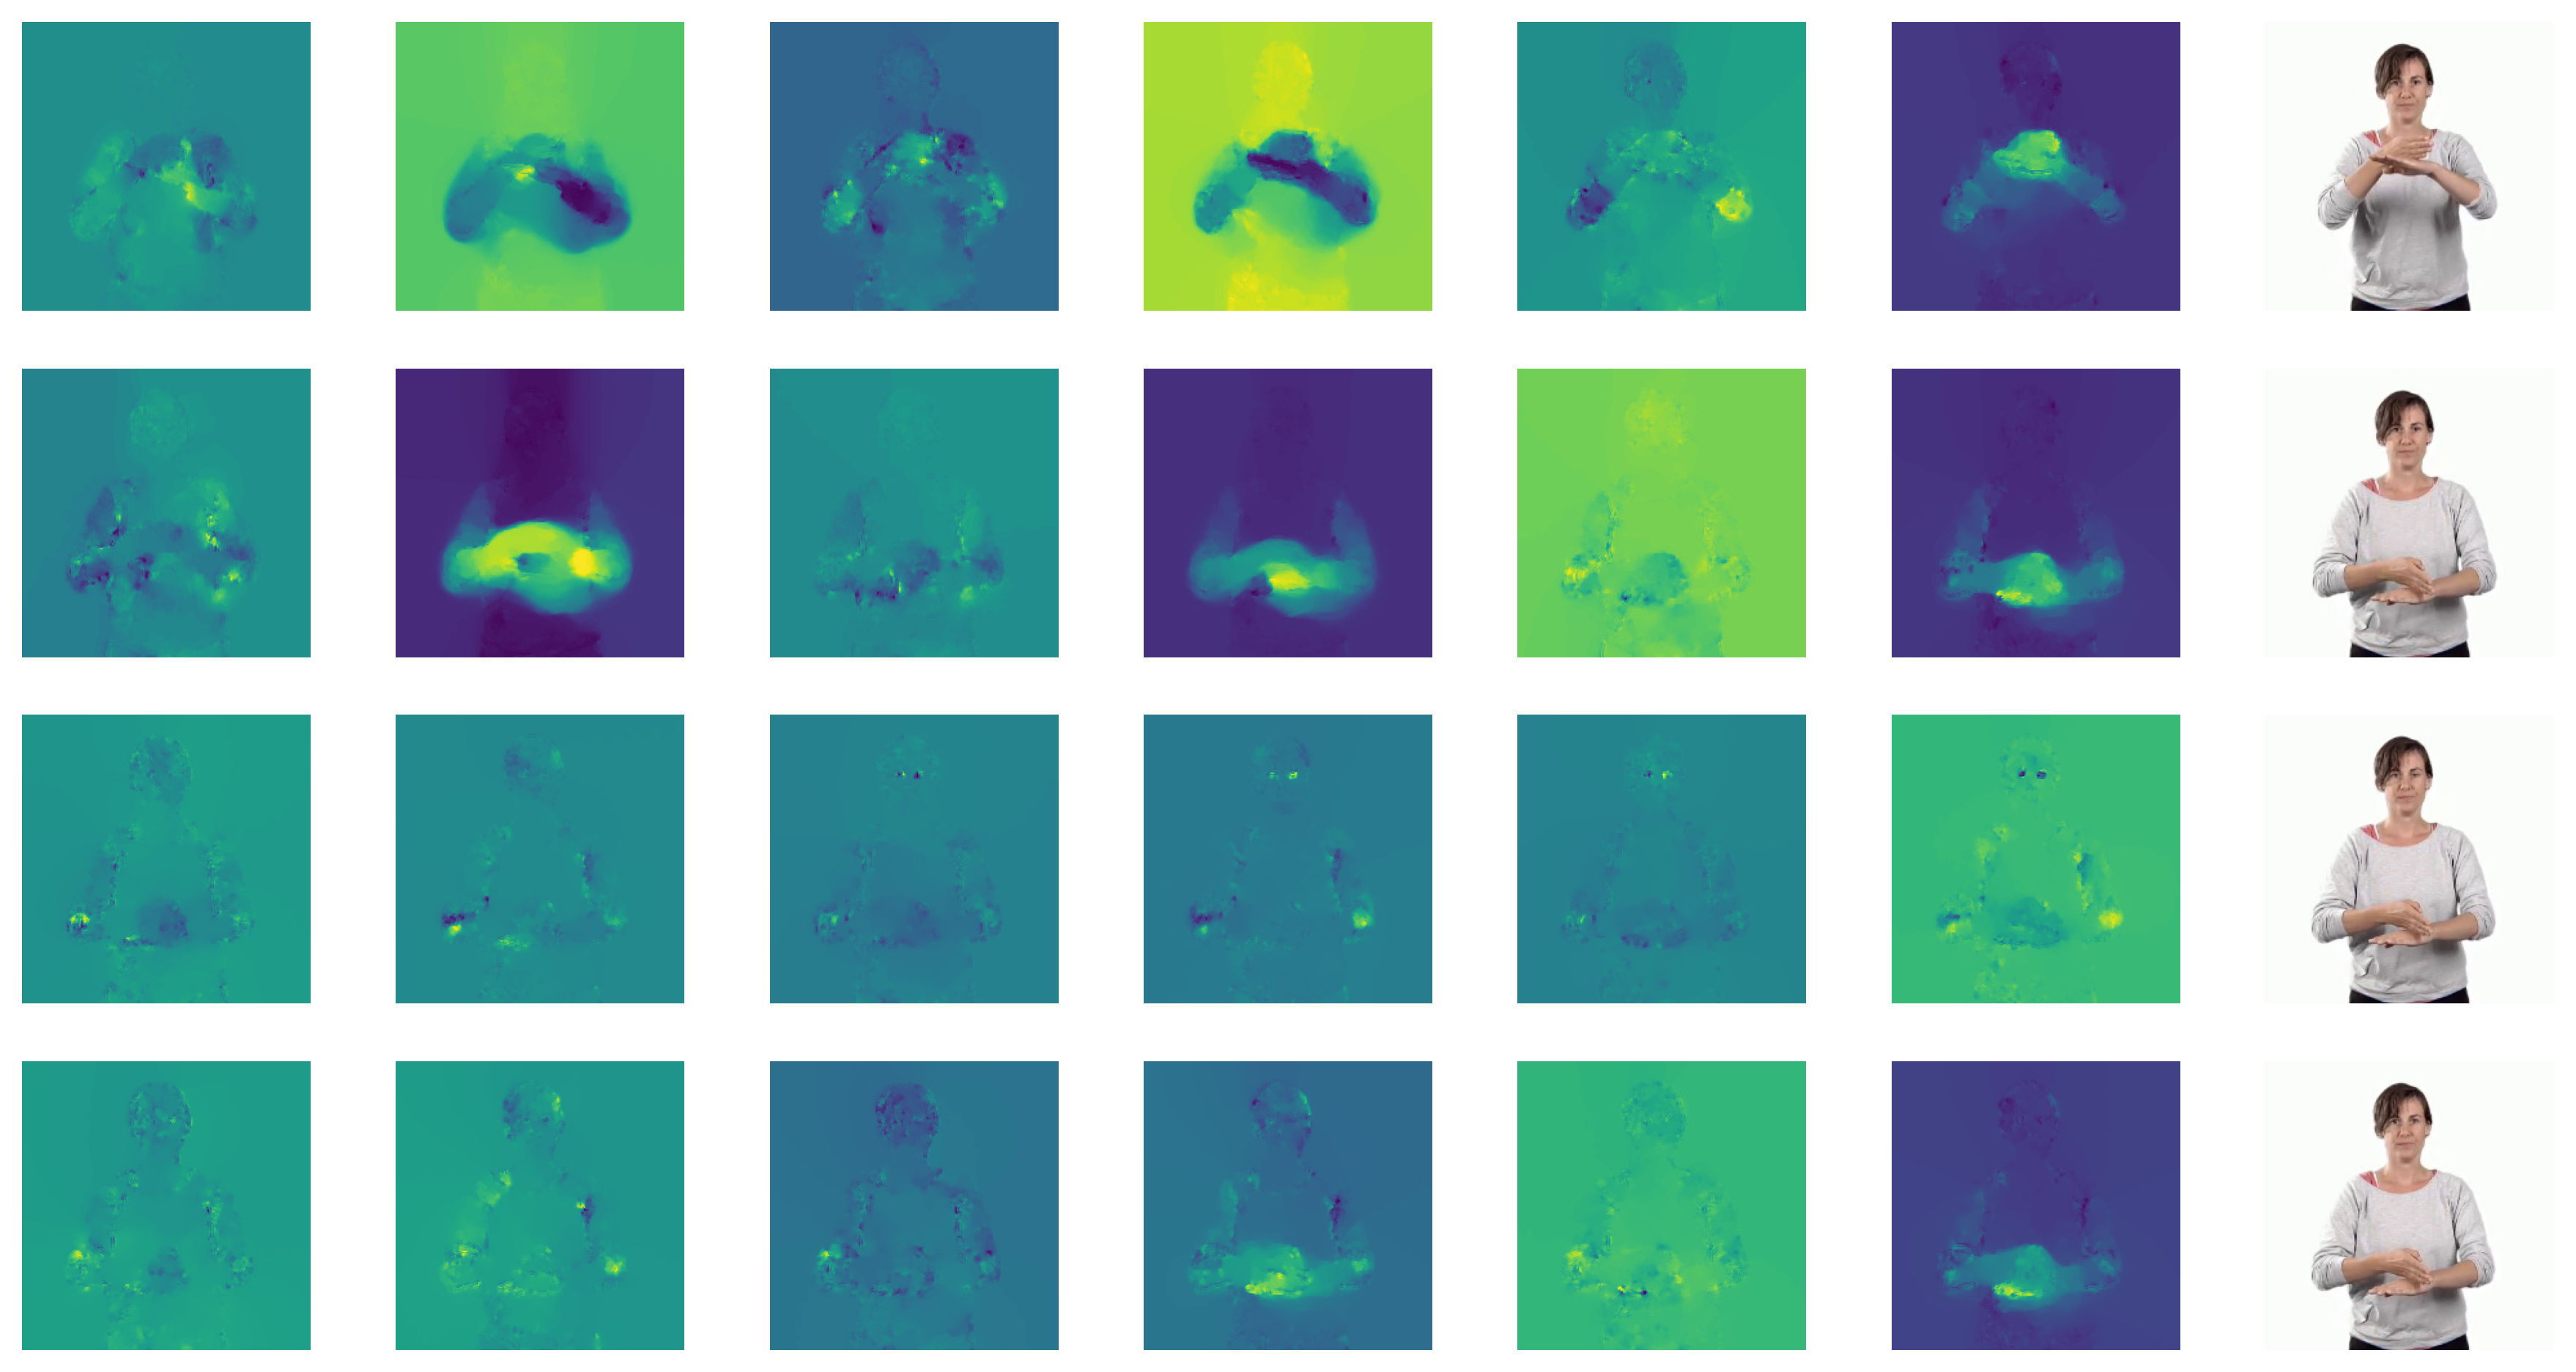

In [40]:
idx = 50
print(f'label: {lbls_np[idx]}')
row = train.loc[train['label'] == lbls_np[idx]]
display(row)
plot_mffs(mffs_np[idx])

In [38]:
use_label = train.loc[train['Person'].map(type) == str, 'label'].sample(1).squeeze()
print(f'use_label: {use_label}')

use_label: 54


In [72]:
Video.from_file(train.loc[train['label'] == use_label, 'file_path'].squeeze())

Video(value=b'\x00\x00\x00\x1cftypmp42\x00\x00\x00\x01isommp41avc1\x00\x00\r\xdcmoov\x00\x00\x00*iods\x00\x00\…

In [73]:
Video.from_file(val.loc[train['label'] == use_label, 'file_path_val'].squeeze())

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

In [36]:
def open_pickle(file_path):
    file_path = f'D:/MEGA/Nijmegen/Master Stage/notebooks/MFF-pytorch/datasets/pickle/{file_path}'
    with bz2.BZ2File(file_path, 'rb') as f:
        record = pickle.load(f)
        mffs, label = record
        
        # random square cropout
        imgs_square = []
        for frame_options in mffs:
            frame_option_idx = len(frame_options) // 2
            mff = frame_options[frame_option_idx]
            for img in mff:
                img_pil = Image.open(io.BytesIO(img))
                img_np = np.array(img_pil)
                
                h, w = img_np.shape[:2]
                offset = np.random.randint(0, w-h)
                imgs_square.append(Image.fromarray(img_np[:, offset:offset+h]))
                
        transforms = torchvision.transforms.Compose([
            Stack2(roll=True, isRGBFlow=True),
            ToTorchFormatTensor(div=True),
            GroupNormalize([0,0,0], [1]),
        ])
        
        mffs = transforms(imgs_square)
        
        return mffs.numpy()